In [100]:
from transformers import CLIPTokenizer, CLIPTextModel
from helperFunctions import VectorQuantizeImage, VecQVAE, FrameDataset
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from einops import rearrange


(np.float64(-0.5), np.float64(6043.5), np.float64(4028.5), np.float64(-0.5))

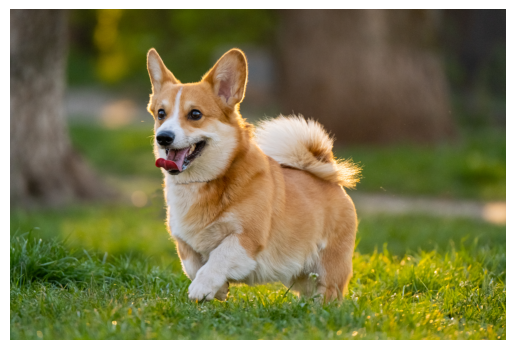

In [101]:
img = Image.open("imageVisualization/testImage.png")
npArray = np.array(img)
plt.imshow(img)
plt.axis('off')

In [102]:
tranform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [103]:
print(npArray.shape)
tensorFrames = tranform(img)
print(tensorFrames.shape)
tensorFrames = tensorFrames/255.0
tensorFrames.shape

(4029, 6044, 3)
torch.Size([3, 128, 128])


torch.Size([3, 128, 128])

In [104]:
codeBookdim = 256
embedDim = 128
hiddenDim = 256
inChannels = 3

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
modelA = VecQVAE(inChannels = inChannels, hiddenDim = hiddenDim, codeBookdim = codeBookdim, embedDim = embedDim).to(device)


In [105]:
modelValA = torch.load("models/VQVAE-GIF-thread-1.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.4930874e-13..1.5069447].


torch.Size([1, 128, 128, 3])


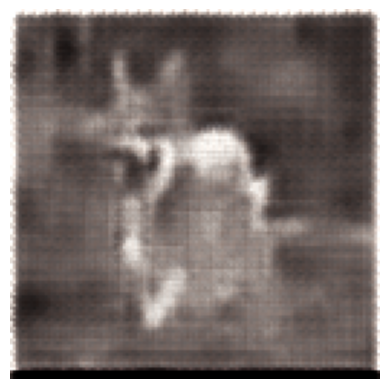

In [109]:
with torch.inference_mode():
    encodedImage = modelA.encodeImage(tensorFrames.unsqueeze(0), )
    decodedImage = modelA.decodeImage(encodedImage)

decodedImage = rearrange(decodedImage, 'b c h w -> b h w c')
npImage = (decodedImage * 255.0).squeeze().squeeze().detach().numpy()
print(decodedImage.shape)
plt.imshow(npImage)
plt.axis('off')
plt.show()

In [6]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

text = "a cat jumping on a bed"
inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad():
    text_embedding = text_encoder(**inputs).last_hidden_state.mean(dim=1)

text_embedding.shape

torch.Size([1, 512])